# Preliminaries: Inspect and Set up environment

In [1]:
# Import all libraries required

# Data Processing and EDA
import datetime
import pandas as pd
import numpy as np

# For bioinformatics tasks
from Bio import SeqIO

# For Machine Learning
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
# Environment
# Show all the output for every print not just the last
from IPython.core.interactiveshell import InteractiveShell
# Configuration and settings
InteractiveShell.ast_node_interactivity = "all"
# To check if in Google Colab
from IPython.core.getipython import get_ipython
# To display all the output in a nicer table
from IPython.display import display

In [3]:
print(datetime.datetime.now())

2024-07-04 08:55:50.690944


In [4]:
!which python

/home/ajvilleg/miniforge3/envs/learn-flu/bin/python


In [5]:
!python --version

Python 3.12.2


In [6]:
!echo $PYTHONPATH

In [7]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
#if 'google.colab' in str(get_ipython()):
    # TODO: if running on Google Colab, install any packages you need to here. For example:
    #!pip install unidecode
    #!pip install category_encoders
    #!pip install scikeras

In [9]:
# Let's minimize randomness
# numpy
np.random.seed(42)
# accelerate
#set_seed(42)


# 1.0 Data Exploration

## 1.1 Load data

In [10]:
# Parse the FASTA file
records = list(SeqIO.parse("/home/ajvilleg/Netdrive/AI/GISAID/EpiFlu_Training/30-Jun-2024/gisaid_epiflu_sequence_2024-06-30.fasta", "fasta"))


In [11]:
# Extract the details from the description of each record
data = []

# Iterate through records for every pair for NA and HA segments
for record1, record2 in zip(records[::2], records[1::2]):
    description1 = record1.description.split('|')
    description2 = record2.description.split('|')

    # Assume the isolate name is the same for both segments
    isolate_name1 = description1[0].strip()
    isolate_name2 = description2[0].strip()
    if isolate_name1 != isolate_name2:
        print(f"Isolate names do not match: {isolate_name1} vs {isolate_name2}")
        raise ValueError("Isolate names do not match")

    # Assume the isolate ID is the same for both segments
    isolate_id1 = description1[1].strip()
    isolate_id2 = description2[1].strip()
    if isolate_id1 != isolate_id2:
        print(f"Isolate IDs do not match: {isolate_id1} vs {isolate_id2}")
        raise ValueError("Isolate IDs do not match")

    # Assume the flu type is the same for both segments
    flu_type1 = description1[2].strip()
    flu_type2 = description2[2].strip()
    if flu_type1 != flu_type2:
        print(f"Flu types do not match: {flu_type1} vs {flu_type2}")
        raise ValueError("Flu types do not match")

    # Assume the lineage is the same for both segments
    lineage1 = description1[3].strip()
    lineage2 = description2[3].strip()
    if lineage1 != lineage2:
        print(f"Lineages do not match: {lineage1} vs {lineage2}")
        raise ValueError("Lineages do not match")

    # The segment labels are different for NA and HA segments
    segment1 = description1[4].strip()
    segment2 = description2[4].strip()  

    # Assume the collection date is the same for both segments
    collection_date1 = description1[5].strip()
    collection_date2 = description2[5].strip()
    if collection_date1 != collection_date2:
        print(f"Collection dates do not match: {collection_date1} vs {collection_date2}")
        raise ValueError("Collection dates do not match")

    # Assume the clade is the same for both segments. This is important as this will be our label for classification
    clade1 = description1[6].strip()
    clade2 = description2[6].strip()
    if clade1 != clade2:
        print(f"Clades do not match: {clade1} vs {clade2}")
        raise ValueError("Clades do not match")

    # The sequences will be different corresopnding to the NA and HA segments
    sequence1 = str(record1.seq)
    sequence2 = str(record2.seq)
    if segment1 == 'HA':
        sequence_ha = sequence1
        sequence_na = sequence2
    else: # segment2 == 'HA'
        sequence_ha = sequence2
        sequence_na = sequence1
    data.append([isolate_name1, isolate_id1, flu_type1, lineage1, sequence_ha, sequence_na, collection_date1, clade1])

df = pd.DataFrame(data, columns=['Isolate_Name', 'Isolate_ID', 'Flu_Type', 'Lineage', 'HA', 'NA', 'Collection Date', 'Clade'])


In [12]:
# Take a look at the data  
display(df)

,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade
0,A/Michigan/136/2018,EPI_ISL_360559,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttctgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttcgat...,2018-01-16,6B.1A
1,A/USA/7C9/2010,EPI_ISL_17760636,A_/_H1N1,pdm09,atgaaggcaatactagtagttctgctatatacatttgcaaccgcaa...,atgaatccaaaccaaaagataataaccattggttcgatctgtatga...,2010-11-01,6B.1
2,A/USA/7C7/2010,EPI_ISL_17760635,A_/_H1N1,pdm09,atgaaggcaatactagtagttctgctatatacatttgcaaccgcaa...,atgaatccaaaccaaaagataataaccattggttcgatctgtatga...,2010-11-01,6B.1
3,A/USA/7K3/1935,EPI_ISL_17760634,A_/_H1N1,pdm09,atgaaggcaatactagtagttctgctatatacatttgcaaccgcaa...,atgaatccaaaccaaaagataataaccattggttcggtctgtatga...,2010-11-01,6B.1
4,A/Michigan/98/2018,EPI_ISL_360571,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttctgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttcgat...,2018-01-08,6B.1A
...,...,...,...,...,...,...,...,...
15414,A/Washington/97/2020,EPI_ISL_2588628,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2020-02-04,6B.1A.5a.2
15415,A/Washington/96/2020,EPI_ISL_2588627,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2020-02-04,6B.1A.5a.2
15416,A/Washington/90/2020,EPI_ISL_2588626,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttctgct...,agtttaaaatgaatccaaaccaaaagataataaccattggctctat...,2020-02-02,6B.1A.5a.1
15417,A/Pennsylvania/164/2020,EPI_ISL_2588633,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2020-02-24,6B.1A.5a.2


## 1.2 EDA

### 1.2.1 Dataframe structure

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15419 entries, 0 to 15418
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Isolate_Name     15419 non-null  object
 1   Isolate_ID       15419 non-null  object
 2   Flu_Type         15419 non-null  object
 3   Lineage          15419 non-null  object
 4   HA               15419 non-null  object
 5   NA               15419 non-null  object
 6   Collection Date  15419 non-null  object
 7   Clade            15419 non-null  object
dtypes: object(8)
memory usage: 963.8+ KB


In [14]:
# Convert all columns to strings except Collection DAte
df = df.astype(str)

# Convert "Collection Date" column to date
df["Collection Date"] = pd.to_datetime(df["Collection Date"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15419 entries, 0 to 15418
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Isolate_Name     15419 non-null  object        
 1   Isolate_ID       15419 non-null  object        
 2   Flu_Type         15419 non-null  object        
 3   Lineage          15419 non-null  object        
 4   HA               15419 non-null  object        
 5   NA               15419 non-null  object        
 6   Collection Date  15419 non-null  datetime64[ns]
 7   Clade            15419 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 963.8+ KB


### 1.2.2 Describe

In [15]:
df.describe()

,Collection Date
count,15419
mean,2017-12-03 02:55:00.914456320
min,2009-01-01 00:00:00
25%,2016-03-03 00:00:00
50%,2019-01-23 00:00:00
75%,2020-01-22 00:00:00
max,2023-04-26 00:00:00


### 1.2.3 Shape

In [16]:
df.shape

(15419, 8)

### 1.2.4 Duplicated rows

In [17]:
# Check for duplicated rows in training data
print(f'df has {df.duplicated().sum()} duplicate rows')
display(df[df.duplicated()])
# Drop duplicates and check again
df.drop_duplicates(inplace=True)
print(f'df has {df.duplicated().sum()} duplicate rows')

df has 1 duplicate rows


,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade
14162,A/Houston/2OS/2009,EPI_ISL_63939,A_/_H1N1,pdm09,aaaagcaacaaaaatgaaggcaatactagtagttctgctatataca...,aaatgaatccaaaccaaaagataataaccattggttcggtctgtat...,2009-05-18,6B.1


df has 0 duplicate rows


### 1.2.5 Missing values / NaN

In [18]:
# Check for missing values X
print("Missing values in df:")
df.isnull().sum()

Missing values in df:


Isolate_Name       0
Isolate_ID         0
Flu_Type           0
Lineage            0
HA                 0
NA                 0
Collection Date    0
Clade              0
dtype: int64

### 1.2.6 Look at sequence length stats

In [19]:
def get_sequence_length(row, column):
    """Calculates the length of the sequence in the specified column."""
    return len(row[column])

ha_sequence_lengths = df.apply(get_sequence_length, axis=1, column="HA")
na_sequence_lengths = df.apply(get_sequence_length, axis=1, column="NA")
print("Sequence lengths in HA columns:")
ha_sequence_lengths.describe()
print("Sequence lengths in NA columns:")
na_sequence_lengths.describe()


Sequence lengths in HA columns:


count    15418.000000
mean      1741.627254
std         22.456070
min       1410.000000
25%       1734.000000
50%       1752.000000
75%       1752.000000
max       1922.000000
dtype: float64

Sequence lengths in NA columns:


count    15418.000000
mean      1428.917175
std         12.398366
min       1410.000000
25%       1420.000000
50%       1433.000000
75%       1433.000000
max       1701.000000
dtype: float64

### 1.2.7 Class imbalance in Clade column

In [20]:
df['Clade'].value_counts()

Clade
6B.1             4862
6B.1A.5a.2a.1    1914
6B.1A.1          1576
6B.1A.5a.1       1538
6B.1A.5b         1304
6B.1A.5a.2       1152
6B.1A.5a          922
6B.1A             590
6B.1A.7           510
6B.1A.5a.2a       373
6B.1A.6           300
6B.1A.3           206
6B.1A.2            82
6B.2               44
6B.1A.5            39
unassigned          6
Name: count, dtype: int64

# 2.0 Data Preparation

### Choose a subset of the entire dataset

In [21]:
# df.shape

# # Sort the DataFrame by Collection Date
# df_sorted = df.sort_values('Collection Date')

# # Calculate the step size for selecting the records
# step_size = len(df_sorted) // 1000

# # Select 1000 records with a uniform distribution
# uniform_records = df_sorted.iloc[::step_size]

# # Set df to the selected records
# df = uniform_records

# df.shape

### 2.1 K-mers and k-mer encoding

In [22]:
# Function to extract kmers (can be reused)
def get_kmers(sequence, k):
  """
  Extracts all k-mers (subsequences of length k) from a DNA sequence.
  """
  kmers = []
  for i in range(len(sequence) - k + 1):
    kmer = sequence[i:i+k]
    kmers.append(kmer)
  return kmers

In [23]:
# Create an empty dictionary to store kmers for each sequence (identified by row index)
kmer_dict = {}

In [24]:
# Extract 12-mers from each sequence and store them in the dictionary
for i, row in df.iterrows():
  # Extract kmers from HA sequence (assuming it exists)
  ha_kmers = []
  if "HA" in row:  # Check if "HA" column exists
    sequence = str(row["HA"])
    ha_kmers = get_kmers(sequence, 12)

  # Extract kmers from NA sequence (assuming it exists)
  na_kmers = []
  if "NA" in row:  # Check if "NA" column exists
    sequence = str(row["NA"])
    na_kmers = get_kmers(sequence, 12)

  # Store kmers separately in the dictionary
  kmer_dict[i] = {
      "HA": ha_kmers,
      "NA": na_kmers,
  }

#### 2.1.1 Use K-mer chunking to optimize memory usage

In [25]:
# Define chunk size (adjust as needed)
chunk_size = 100

One-Hot Encoding (DISABLED) (Kernel crashing even with only 1000 records and k-mer chunking, chunk_size = 10)

In [26]:
# def process_chunk(chunk_dict):
#   """
#   Processes a chunk of data from the kmer_dict and returns encoded features.
#   """
#   chunk_ha_features, chunk_na_features = [], []
#   ha_kmer_encoder = OneHotEncoder(handle_unknown='ignore')  # OHE for each chunk
#   na_kmer_encoder = OneHotEncoder(handle_unknown='ignore')  # OHE for each chunk

#   for kmer_dict_row in chunk_dict.values():
#     # Extract HA and NA kmers
#     ha_kmers = kmer_dict_row["HA"]
#     na_kmers = kmer_dict_row["NA"]

#     # Encode HA and NA kmers (using encoders local to the function)
#     ha_encoded = ha_kmer_encoder.fit_transform(np.array([ha_kmers]).reshape(-1, 1))
#     na_encoded = na_kmer_encoder.fit_transform(np.array([na_kmers]).reshape(-1, 1))

#     # Convert CSR matrices to dense arrays for appending (to deal with OHE sparse matrices error)
#     ha_encoded = ha_encoded.toarray()  # Convert to dense array
#     na_encoded = na_encoded.toarray()  # Convert to dense array

#     # Append features (adapt dimensions based on your encoding)
#     chunk_ha_features.append(ha_encoded.flatten())
#     chunk_na_features.append(na_encoded.flatten())

#   return chunk_ha_features, chunk_na_features

# # Iterate through kmer_dict in chunks
# ha_features = []
# na_features = []
# for i in range(0, len(kmer_dict), chunk_size):
#   # Get a chunk of data
#   chunk_dict = dict(list(kmer_dict.items())[i:i + chunk_size])

#   # Process features for the chunk
#   chunk_ha_features, chunk_na_features = process_chunk(chunk_dict)

#   # Append features from the chunk
#   ha_features.extend(chunk_ha_features)
#   na_features.extend(chunk_na_features)

Count-based Encoding (K-mer Chunking) 

In [27]:
def process_chunk(chunk_dict):
    """
    Processes a chunk of data from the kmer_dict and returns count-based features,
    keeping HA and NA k-mer counts separate to avoid overlap issues.
    """
    chunk_ha_features, chunk_na_features = [], []

    for kmer_dict_row in chunk_dict.values():
        # Extract HA and NA kmers
        ha_kmers = kmer_dict_row["HA"]
        na_kmers = kmer_dict_row["NA"]

        # Count occurrences of kmers for HA and NA separately
        ha_kmer_counts = Counter(ha_kmers)
        na_kmer_counts = Counter(na_kmers)

        # Extract counts and append as features (ensure consistent order for all chunks)
        all_kmers = list(set(ha_kmer_counts.keys()) | set(na_kmer_counts.keys()))  # Get unique k-mers

        chunk_ha_features.append([ha_kmer_counts[kmer] if kmer in ha_kmer_counts else 0 for kmer in all_kmers])
        chunk_na_features.append([na_kmer_counts[kmer] if kmer in na_kmer_counts else 0 for kmer in all_kmers])

    return chunk_ha_features, chunk_na_features

In [28]:
# Iterate through kmer_dict in chunks
ha_features = []
na_features = []
for i in range(0, len(kmer_dict), chunk_size):
  # Get a chunk of data
  chunk_dict = dict(list(kmer_dict.items())[i:i + chunk_size])

  # Process features for the chunk
  chunk_ha_features, chunk_na_features = process_chunk(chunk_dict)

  # Append features from the chunk
  ha_features.extend(chunk_ha_features)
  na_features.extend(chunk_na_features)

### 2.3 Define X and y and Train Test Split

In [29]:
X = []

# Assuming ha_features and na_features contain lists
ha_features = [np.array(l) for l in ha_features]  # Convert lists to arrays
na_features = [np.array(l) for l in na_features]  # Convert lists to arrays

# The arrays in ha_features and na_features have different shapes, we need to ensure that the arrays in ha_features and na_features have the same shape before concatenating them.

In [30]:
# Pad shorter arrays in ha_features and na_features with zeros
# Find the maximum number of features across all arrays
max_feature_count = max(arr.shape[0] for arr in ha_features + na_features)

# Pad shorter arrays in ha_features and na_features with zeros
for i in range(len(ha_features)):
  ha_features[i] = np.pad(ha_features[i], (0, max_feature_count - len(ha_features[i])), mode='constant')

for i in range(len(na_features)):
  na_features[i] = np.pad(na_features[i], (0, max_feature_count - len(na_features[i])), mode='constant')

# Now concatenate by sample/instance (axis=1, instead of axis=0 which is stacking on top of each other) the padded arrays (assuming na_features have consistent shapes)
X = np.concatenate((ha_features, na_features), axis=1)

In [31]:
y = []
le = LabelEncoder()

# Fit the LabelEncoder to all unique classes (call only once)
le.fit(df['Clade'])

for index in df.index:
  clade_label = le.transform(np.array([df.loc[index, "Clade"]]))[0]
  y.append(clade_label)

LabelEncoder()

In [32]:
# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Set random_state for reproducibility

In [33]:
from sklearn.linear_model import LogisticRegression
# Train a Logistic Regression model
model = LogisticRegression(multi_class='ovr', solver='lbfgs')
model.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

# 3.0 Evaluation

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Accuracy: Proportion of correctly predicted samples
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Precision: Ratio of true positives to all predicted positives
precision = precision_score(y_test, y_pred, average='weighted')  # Weighted average for multi-class
print("Precision:", precision)

# Recall: Ratio of true positives to all actual positives
recall = recall_score(y_test, y_pred, average='weighted')  # Weighted average for multi-class
print("Recall:", recall)

# F1-score: Harmonic mean of precision and recall
f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted average for multi-class
print("F1-score:", f1)

Accuracy: 0.9730869001297017
Precision: 0.9721757186657736
Recall: 0.9730869001297017
F1-score: 0.9721701542845047


Accuracy: 0.9730869001297017

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       953
           1       0.87      0.88      0.87       110
           2       0.96      0.98      0.97       330
           3       1.00      0.94      0.97        18
           4       0.90      0.76      0.82        37
           5       0.71      0.56      0.62         9
           6       0.98      0.95      0.96       209
           7       0.98      0.99      0.99       329
           8       0.97      1.00      0.98       217
           9       0.99      0.89      0.93        79
          10       0.98      0.99      0.99       389
          11       0.98      0.99      0.99       267
          12       0.95      0.80      0.87        45
          13       0.91      0.98      0.94        86
          14       0.50      0.20      0.29         5
          15       0.00      0.00      0.00         1

    accuracy               

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Clade')

Text(70.72222222222221, 0.5, 'True Clade')

Text(0.5, 1.0, 'Confusion Matrix')

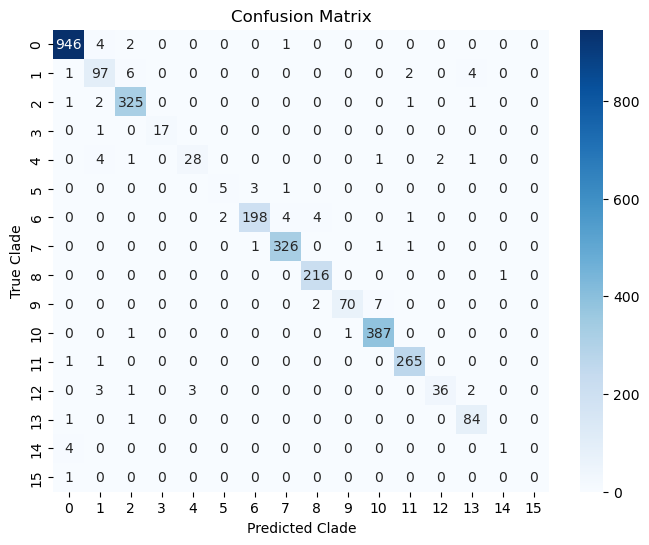

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Accuracy: Proportion of correctly predicted samples
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix with Seaborn
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

# Create a new figure for the confusion matrix
plt.figure(figsize=(8, 6))

# Create heatmap using seaborn
heatmap(cm, annot=True, fmt="d", cmap="Blues")  # Customize heatmap with annotations, format, and colormap

# Add labels and title
plt.xlabel("Predicted Clade")
plt.ylabel("True Clade")
plt.title("Confusion Matrix")

# Show the confusion matrix
plt.show()
